In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import statsmodels.api as sm
from itertools import product
from math import sqrt
from sklearn.metrics import mean_squared_error 

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 18, "axes.labelsize" : 12, 
            "xtick.labelsize" : 14, "ytick.labelsize" : 14 })

In [2]:
df = pd.read_csv('Bitcoin.csv')
df['Date'] = pd.to_datetime(df.Date)
df = df.drop(['Unnamed: 2', 'Market Cap'], axis=1)
df.set_index('Date', inplace=True)
df = df.resample('D').mean()
df['close_ffill'] = df['Open'].fillna(method='ffill')
df = df[df.index.year > 2019]

### Stationarity Check and Seasonal Decomposition

If a time series is stationary, it implies the lack of broad trends (changes in mean and variance over time) in the data. This is important as a consideration in time series forecasting.

Dickey–Fuller test: p=0.810621


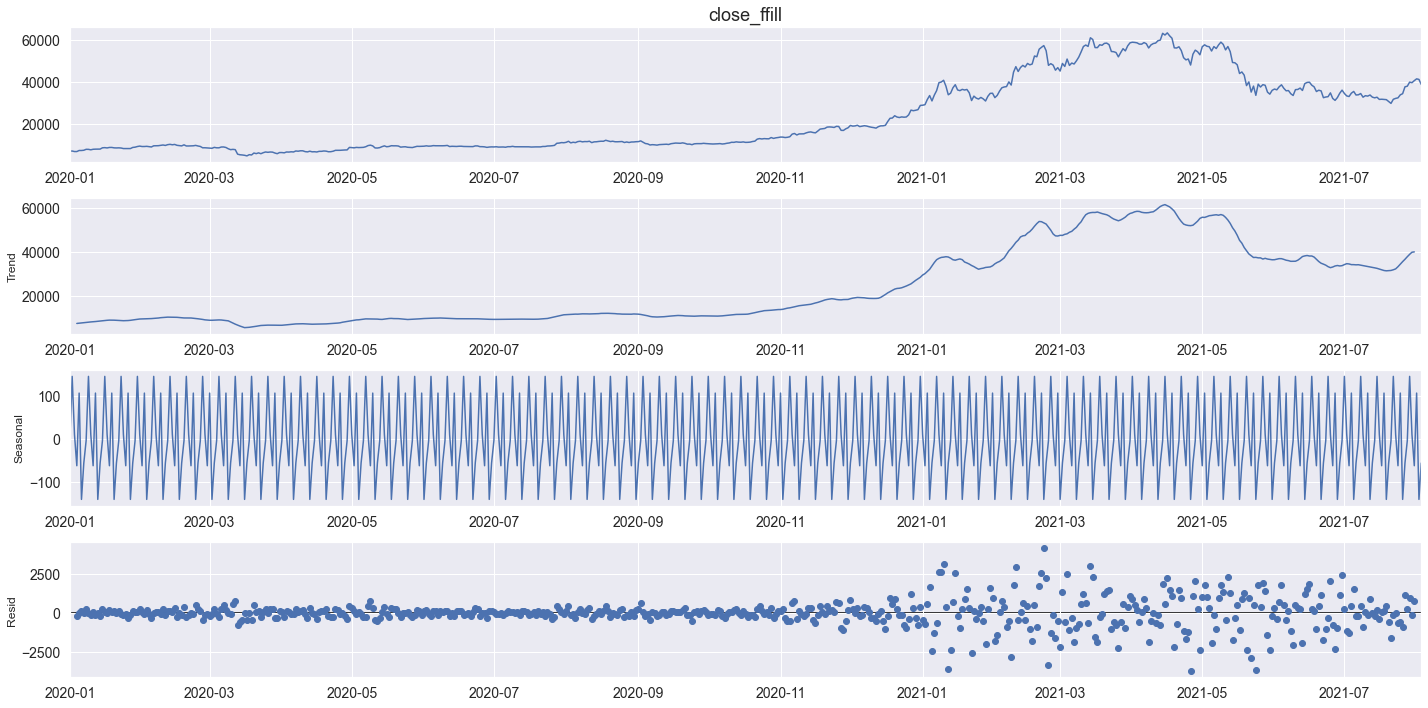

In [3]:
seasonal_decompose(df['close_ffill']).plot()
print("Dickey–Fuller test: p=%f" % adfuller(df['close_ffill'])[1])
plt.show()

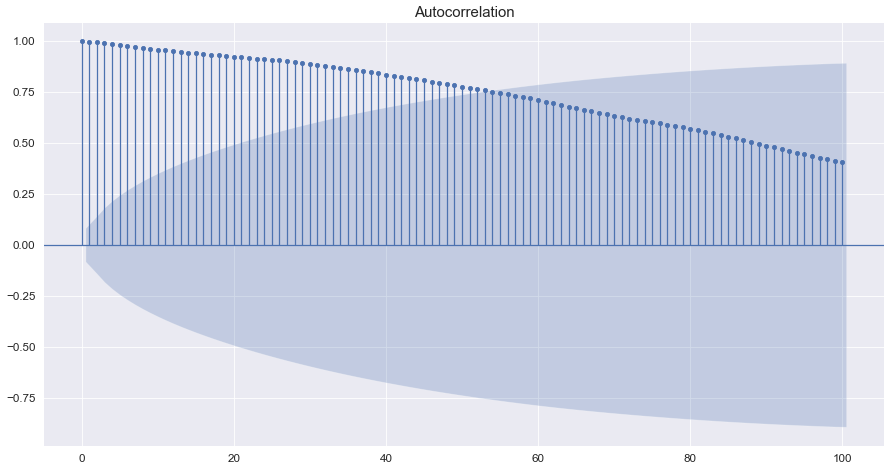

In [4]:
plt.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':60})

plot_acf(df.close_ffill[13:].values.squeeze(), lags=100)
plt.tight_layout()

There are not many spikes in the plots outside the insignificant zone (shaded) so there may not be enough information available in the residuals to be extracted by AR and MA models.

There may be a seasonal component available in the residuals at the lags of quarters (3 months) represented by spikes at these intervals. But probably not significant.

#### ARIMA Model 
AutoRegressive Integrated Moving Average

ARIMA models are denoted with the notation ARIMA(p, d, q). These parameters account for seasonality, trend, and noise in datasets:

p - the number of lag observations to include in the model, or lag order. (AR)
d - the number of times that the raw observations are differenced, or the degree of differencing. (I)
q - the size of the moving average window, also called the order of moving average.(MA)

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model. A value of 0 for a parameter indicates to not use that element of the model.

#### Parameter Selection
We will iteratively explore different combinations of parameters. For each combination we fit a new ARIMA model with SARIMAX() and assess its overall quality.

We will use the AIC (Akaike Information Criterion) value, returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.


In [5]:
qs = range(0, 4)
ps = range(0, 4)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(df.close_ffill, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [6]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

   parameters          aic
10     (2, 2)  9910.030969
11     (2, 3)  9910.512034
15     (3, 3)  9913.454557
6      (1, 2)  9918.814055
9      (2, 1)  9919.194036


Note the AICs are negative but this is not a problem.

Usually, AIC is positive; however, it can be shifted by any additive constant, and some shifts can result in negative values of AIC. [...] It is not the absolute size of the AIC value, it is the relative values over the set of models considered, and particularly the differences between AIC values, that are important.

Ref: Model Selection and Multi-model Inference: A Practical Information-theoretic Approach (Burnham and Anderson, 2004)

In [7]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:            close_ffill   No. Observations:                  581
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -4950.015
Date:                Fri, 11 Feb 2022   AIC                           9910.031
Time:                        18:53:14   BIC                           9931.846
Sample:                    01-01-2020   HQIC                          9918.536
                         - 08-03-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3340      0.019     70.162      0.000       1.297       1.371
ar.L2         -0.9052      0.019    -48.230      0.000      -0.942      -0.868
ma.L1         -1.3619      0.009   -152.122      0.0

#### Analysis of Results 
The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

In [8]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])


Dickey–Fuller test:: p=0.000000


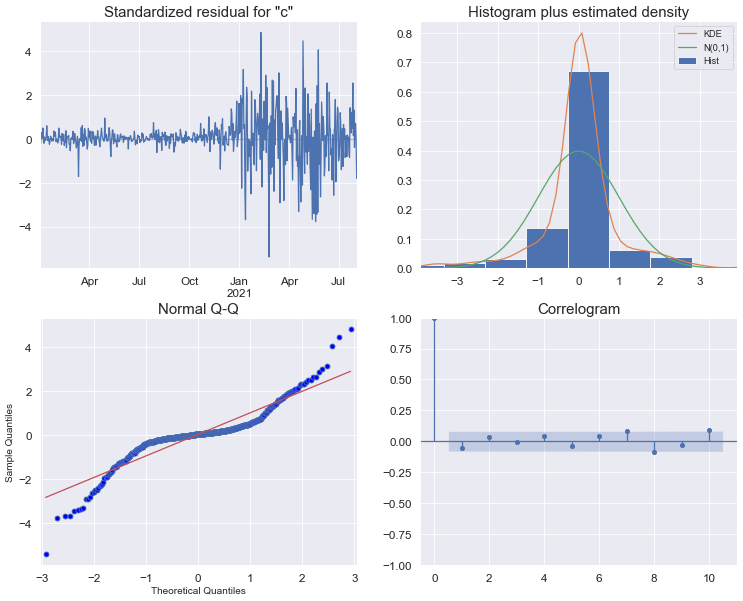

In [9]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In the histogram (top right), the KDE line should follow the N(0,1) line (normal distribution with mean 0, standard deviation 1) closely. This is an indication whether the residuals are normally distributed or not.

In the Q-Q-plot the ordered distribution of residuals (blue dots) should follow the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is an indication whether the residuals are normally distributed.

The standardized residual plot doesn't display any obvious seasonality. 
This is confirmed by the autocorrelation plot, which shows that the time series residuals have low correlation with lagged versions of itself.

In [10]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

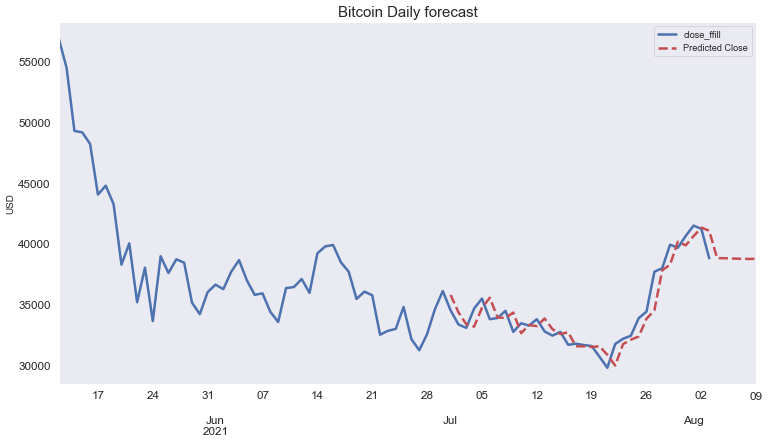

In [11]:
# Prediction
btc_month_pred = df[['close_ffill']]
date_list = [datetime(2021, 8, 4), datetime(2021, 8, 5), datetime(2021, 8, 6),datetime(2021, 8, 7),datetime(2021, 8, 8),datetime(2021, 8, 9)]
future = pd.DataFrame(index=date_list, columns= df.columns)
btc_month_pred = pd.concat([btc_month_pred, future])

#btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
# btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2021, 7, 1), end=datetime(2021, 8, 9)), lmbda)
btc_month_pred['forecast'] = best_model.predict(start=datetime(2021, 7, 1), end=datetime(2021, 8, 9))

btc_month_pred.close_ffill[-90:].plot(linewidth=3)
btc_month_pred.forecast[-90:].plot(color='r', ls='--', label='Predicted Close', linewidth=3)
plt.legend()
plt.grid()
plt.title('Bitcoin Daily forecast')
plt.ylabel('USD')
plt.show()

Text(0, 0.5, 'USD')

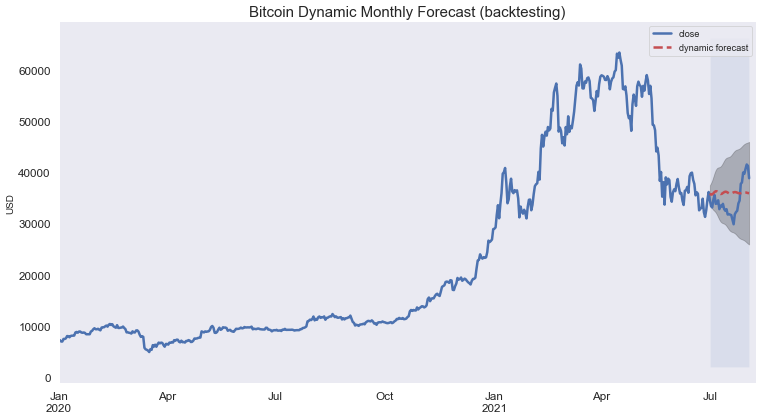

In [12]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2021-07-01')
t2 = pd.to_datetime('2021-08-03')
btc_month_dynamic = best_model.get_prediction(start=t1, end=t2, dynamic=True, full_results=True)
btc_month_pred['dynamic_forecast'] = btc_month_dynamic.predicted_mean

# Taking 80% confidence interval because the 95% blows out too high to visualise
pred_dynamic_ci = btc_month_dynamic.conf_int(alpha=0.2)
pred_dynamic_ci['lower close_ffill'] = pred_dynamic_ci['lower close_ffill']
pred_dynamic_ci['upper close_ffill'] = pred_dynamic_ci['upper close_ffill']

# Plot
# plt.ylim((0,20000))

btc_month_pred.close_ffill[:].plot(label='close', linewidth=3)
btc_month_pred.dynamic_forecast.plot(color='r', ls='--', label='dynamic forecast', linewidth=3)

plt.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha=.1, zorder=-1)

plt.legend()
plt.title('Bitcoin Dynamic Monthly Forecast (backtesting)')
plt.grid()
plt.ylabel('USD')

Text(0, 0.5, 'USD')

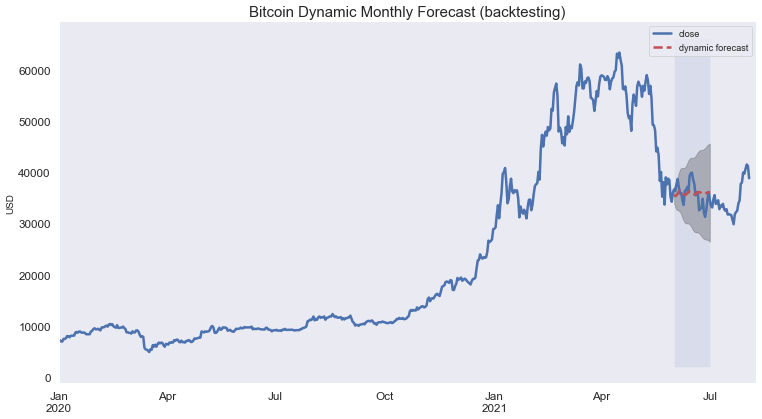

In [13]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2021-06-01')
t2 = pd.to_datetime('2021-07-01')
btc_month_dynamic = best_model.get_prediction(start=t1, end=t2, dynamic=True, full_results=True)
btc_month_pred['dynamic_forecast'] = btc_month_dynamic.predicted_mean

# Taking 80% confidence interval because the 95% blows out too high to visualise
pred_dynamic_ci = btc_month_dynamic.conf_int(alpha=0.2)
pred_dynamic_ci['lower close_ffill'] = pred_dynamic_ci['lower close_ffill']
pred_dynamic_ci['upper close_ffill'] = pred_dynamic_ci['upper close_ffill']

# Plot
# plt.ylim((0,20000))

btc_month_pred.close_ffill[:].plot(label='close', linewidth=3)
btc_month_pred.dynamic_forecast.plot(color='r', ls='--', label='dynamic forecast', linewidth=3)

plt.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha=.1, zorder=-1)

plt.legend()
plt.title('Bitcoin Dynamic Monthly Forecast (backtesting)')
plt.grid()
plt.ylabel('USD')

### SARIMAX Model 
Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

I didn't expect the bitcoin data to display any seasonality but apparently it does display slight seasonality. So lets try to improve the model by using SARIMA.

When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

I have tried out this model with yearly and quarterly periods (toggle the commented out lines to see 12-month seasonal).

#### Parameter Selection
The same process of parameter selection for seasonal ARIMA. For each combination we fit a new seasonal ARIMA model with SARIMAX() and assess its overall quality.

In [14]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
#        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        model = SARIMAX(df.close_ffill, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [42]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters          aic
17  (0, 2, 2, 1)  9868.993013
41  (2, 0, 2, 1)  9869.584161
5   (0, 0, 2, 1)  9870.063379
23  (1, 0, 2, 1)  9870.179858
11  (0, 1, 2, 1)  9870.411569
                                      SARIMAX Results                                      
Dep. Variable:                         close_ffill   No. Observations:                  581
Model:             SARIMAX(0, 1, 2)x(2, 1, [1], 4)   Log Likelihood               -4928.497
Date:                             Mon, 04 Oct 2021   AIC                           9868.993
Time:                                     12:49:23   BIC                           9895.130
Sample:                                 01-01-2020   HQIC                          9879.186
                                      - 08-03-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----

In [43]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[31:])[1])

Dickey–Fuller test:: p=0.000000


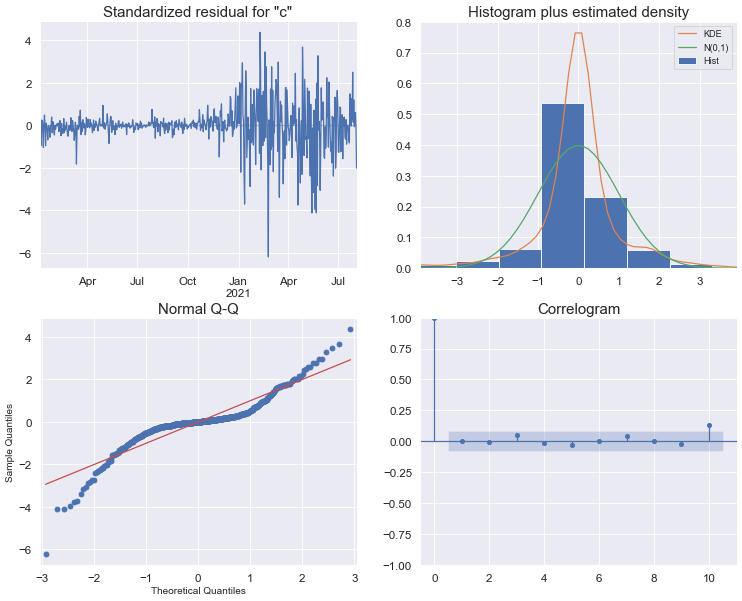

In [44]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Dickey–Fuller test:: p=0.000000


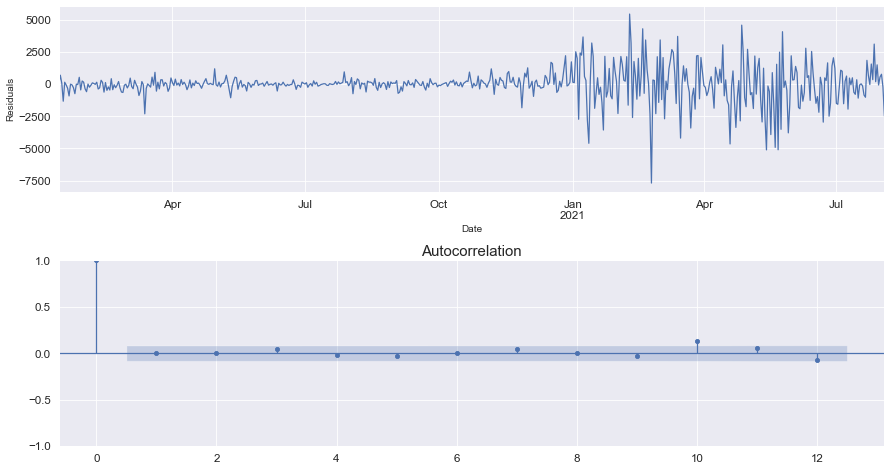

In [45]:
# STL-decomposition
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
#sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(best_model.resid[7:].values.squeeze(), lags=12, ax=ax)

print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[31:])[1])

plt.tight_layout()

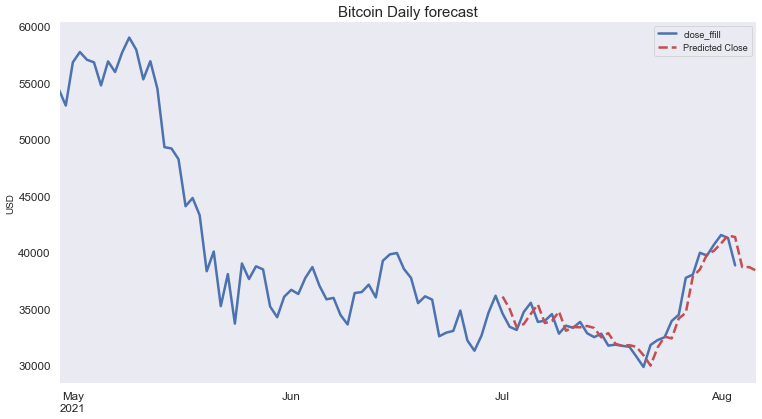

In [46]:
# Prediction
btc_month_sarima = df[['close_ffill']]
date_list = [datetime(2021, 8, 4), datetime(2021, 8, 5), datetime(2021, 8, 6)]
future = pd.DataFrame(index=date_list, columns= df.columns)
btc_month_sarima = pd.concat([btc_month_sarima, future])

#btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
btc_month_sarima['forecast'] = best_model.predict(start=datetime(2021, 7, 1), end=datetime(2021, 8, 6))

btc_month_sarima.close_ffill[-100:].plot(linewidth=3)
btc_month_sarima.forecast[-100:].plot(color='r', ls='--', label='Predicted Close', linewidth=3)
plt.legend()
plt.grid()
plt.title('Bitcoin Daily forecast')
plt.ylabel('USD')
plt.show()

#### Validation 
A simple indicator of how accurate out forecast is is the root mean square error (RMSE). So lets get a baseline and then calcualte the RMSE for the one-step ahead predictions starting from 2015, through to the end of 2017.

#### Baseline 
The naive forecast, where the observation from the previous time step is used as the prediction for the observation at the next time step, can be taken as a simple baseline.

In [47]:
from math import sqrt
from sklearn.metrics import mean_squared_error 

In [355]:
btc_month_predict = df['2021-07-01':'2021-08-01']

# Get a naive forecast
close_history = [x for x in btc_month_predict['close_ffill']]
predictions = list()
for i in range(len(btc_month_predict)):
    # predict
    predictions.append(close_history[-1])
    # update observation
    close_history.append(btc_month_predict.iloc[i]['close_ffill'])
    
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(btc_month_predict['close_ffill'], predictions))
print('RMSE: %.2f' % rmse)

RMSE: 1755.05


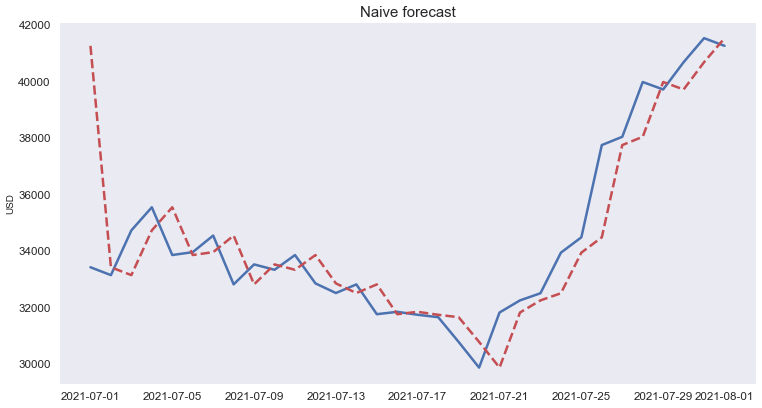

In [356]:
# Plot predictions vs actual
btc_month_predict['naive_forecast'] = predictions
plt.plot(btc_month_predict['close_ffill'],  linewidth=3)
plt.plot(btc_month_predict['naive_forecast'], color='r', ls='--', label='forecast', linewidth=3)
plt.title('Naive forecast')
plt.ylabel('USD')
plt.grid()

### SARIMA

In [48]:
y_forecasted = btc_month_sarima.forecast
y_truth = btc_month_sarima['2021-07-01':'2021-08-03'].close_ffill

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 1130.66


SARIMA does better than the naive forecast when measuring the MSE on a month-by-month prediction basis, ie: Using the actual close price of the last month in order to predict the close price of the next month.

A better representation of longer-term predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

In the code chunk below, we specify to start computing the dynamic forecasts and confidence intervals from mid 2017 onwards.

Text(0, 0.5, 'USD')

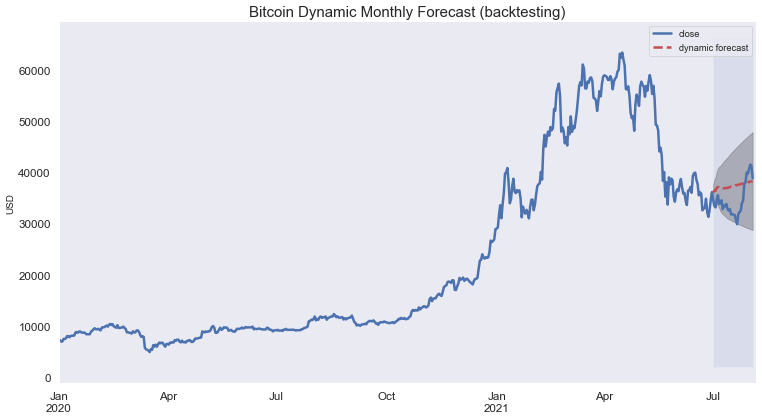

In [49]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2021-07-01')
t2 = pd.to_datetime('2021-08-03')
btc_month_dynamic = best_model.get_prediction(start=t1, end=t2, dynamic=True, full_results=True)
btc_month_sarima['dynamic_forecast'] = btc_month_dynamic.predicted_mean

# Taking 80% confidence interval because the 95% blows out too high to visualise
pred_dynamic_ci = btc_month_dynamic.conf_int(alpha=0.2)
pred_dynamic_ci['lower close_ffill'] = pred_dynamic_ci['lower close_ffill']
pred_dynamic_ci['upper close_ffill'] = pred_dynamic_ci['upper close_ffill']

# Plot
# plt.ylim((0,20000))

btc_month_sarima.close_ffill.plot(label='close', linewidth=3)
btc_month_sarima.dynamic_forecast.plot(color='r', ls='--', label='dynamic forecast', linewidth=3)

plt.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha=.1, zorder=-1)

plt.legend()
plt.title('Bitcoin Dynamic Monthly Forecast (backtesting)')
plt.grid()
plt.ylabel('USD')

Text(0, 0.5, 'USD')

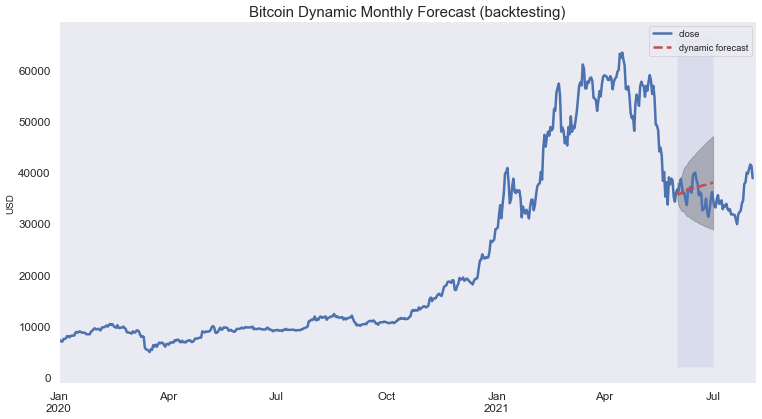

In [50]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2021-06-01')
t2 = pd.to_datetime('2021-07-01')
btc_month_dynamic = best_model.get_prediction(start=t1, end=t2, dynamic=True, full_results=True)
btc_month_sarima['dynamic_forecast'] = btc_month_dynamic.predicted_mean

# Taking 80% confidence interval because the 95% blows out too high to visualise
pred_dynamic_ci = btc_month_dynamic.conf_int(alpha=0.2)
pred_dynamic_ci['lower close_ffill'] = pred_dynamic_ci['lower close_ffill']
pred_dynamic_ci['upper close_ffill'] = pred_dynamic_ci['upper close_ffill']

# Plot
# plt.ylim((0,20000))

btc_month_sarima.close_ffill.plot(label='close', linewidth=3)
btc_month_sarima.dynamic_forecast.plot(color='r', ls='--', label='dynamic forecast', linewidth=3)

plt.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha=.1, zorder=-1)

plt.legend()
plt.title('Bitcoin Dynamic Monthly Forecast (backtesting)')
plt.grid()
plt.ylabel('USD')

### Prophet

In [51]:
from fbprophet import Prophet

In [52]:
df_prophet = df[['close_ffill']].reset_index()
df_prophet.columns = ['ds', 'y']

In [53]:
df_prophet.head()

,ds,y
0,2020-01-01,7158.22
1,2020-01-02,7216.23
2,2020-01-03,6960.58
3,2020-01-04,6960.58
4,2020-01-05,7462.59


In [54]:
train_df = df_prophet[df_prophet.ds < '2021-07-01']
test_df = df_prophet[df_prophet.ds >= '2021-07-01']

In [55]:
train_df.head()

,ds,y
0,2020-01-01,7158.22
1,2020-01-02,7216.23
2,2020-01-03,6960.58
3,2020-01-04,6960.58
4,2020-01-05,7462.59


In [56]:
m = Prophet()
m.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [57]:
future = test_df[['ds']]

In [58]:
forecast = m.predict(future)

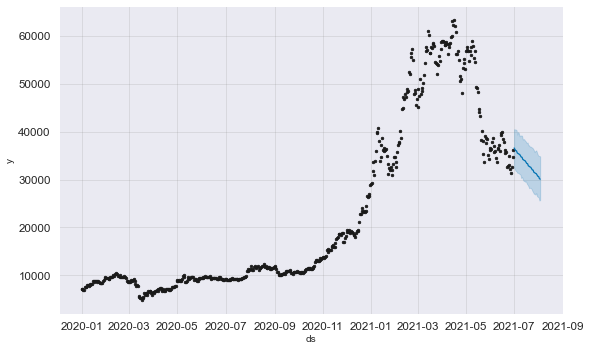

In [59]:
m.plot(forecast)
plt.show()

In [60]:
test_df['forecast'] = forecast['yhat'].values
test_df['upper'] = forecast['yhat_upper'].values
test_df['lower'] = forecast['yhat_lower'].values

test_df = test_df.round(2)

test_df.head()

,ds,y,forecast,upper,lower
547,2021-07-01,34585.00,36602.26,40528.11,32487.20
548,2021-07-02,33422.00,36320.62,40474.96,32140.07
549,2021-07-03,33142.64,36041.35,40460.22,31825.81
550,2021-07-04,34728.55,36006.90,40349.36,31720.54
551,2021-07-05,35547.25,35543.71,39378.97,31419.68


In [61]:
train_df

,ds,y
0,2020-01-01,7158.22
1,2020-01-02,7216.23
2,2020-01-03,6960.58
3,2020-01-04,6960.58
4,2020-01-05,7462.59
...,...,...
542,2021-06-26,32214.53
543,2021-06-27,31305.79
544,2021-06-28,32635.78
545,2021-06-29,34677.77


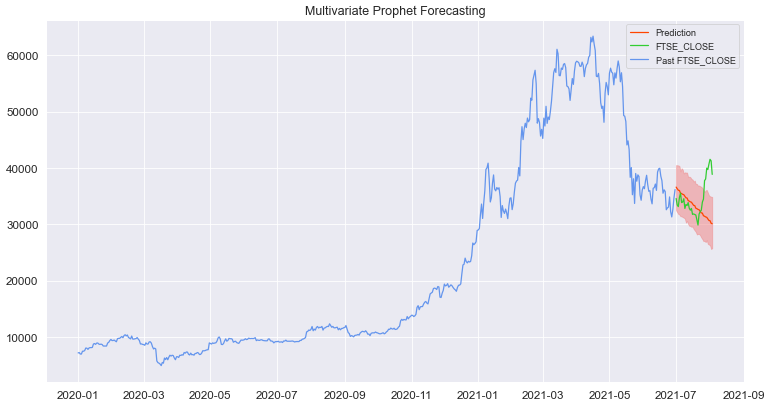

In [62]:
f, ax = plt.subplots(figsize=(15,8))

# past = train_df[train_df.ds >= '2020-11-01'].dropna()
ax.plot(test_df.set_index('ds')[['forecast']], color = 'orangered', label='Prediction')
ax.plot(test_df.set_index('ds')[['y']], color = 'limegreen', label='FTSE_CLOSE')
ax.plot(train_df.set_index('ds')[['y']], color = 'cornflowerblue', label='Past FTSE_CLOSE')


ax.fill_between(test_df.ds, test_df.lower, test_df.upper, color='lightcoral', alpha=0.5)
# ax.fill_between(test.ds, test.low, test.high, color='lightgreen', alpha=0.5)
# ax.fill_between(past.ds, past.low, past.high, color='lightskyblue', alpha=0.5)

ax.set_title("Multivariate Prophet Forecasting", size = 15)
ax.legend()

plt.show()